# Homework 2 Canny
Name Surname: Önder Görmez  
Student No: 21501035

* Implement the Canny edge detection algorithm yourself.

In [1]:
import matplotlib.pyplot as pyplot
import numpy as numpy
import cv2 as open_cv
import copy as copy

import common as common

orginal_img = open_cv.imread('../images/onder.jpg',0)

## Noise Reduction

Since edge detection is susceptible to noise in the image, first step is to remove the noise in the image with a 5x5 Gaussian filter. [[1]](https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html)

Text(0.5, 1.0, 'Filtered Image')

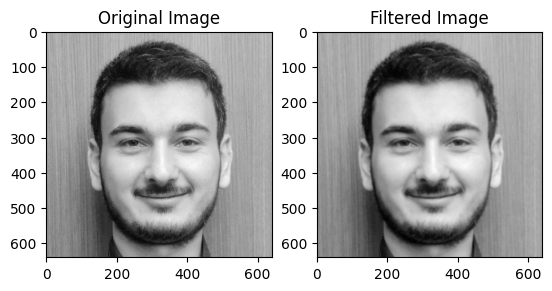

In [2]:
sigma = numpy.sqrt(2)
kernel_size = 5
kernel = common.twoDimensionalGaussianKernel(sigma, kernel_size)
image_filtered = open_cv.filter2D(orginal_img, -1, kernel)

pyplot.subplot(121)
pyplot.imshow(orginal_img,cmap = 'gray')
pyplot.title('Original Image')

pyplot.subplot(122)
pyplot.imshow(image_filtered,cmap = 'gray')
pyplot.title('Filtered Image')

## Finding Intensity Gradient of the Image

Smoothened image is then filtered with a Sobel kernel in both horizontal and vertical direction to get first derivative in horizontal direction (Gx) and vertical direction (Gy). [[1]](https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html)

In [3]:
def sobelFilter(img):
    Kx = numpy.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], numpy.float32)
    Ky = numpy.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], numpy.float32)

    Ix = open_cv.filter2D(img, -1, Kx)
    Iy = open_cv.filter2D(img, -1, Ky)

    G = numpy.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = numpy.arctan2(Iy, Ix)
    return (G, theta)

gradientMat, thetaMat = sobelFilter(image_filtered)

## Non-maximum Suppression
After getting gradient magnitude and direction, a full scan of image is done to remove any unwanted pixels which may not constitute the edge. For this, at every pixel, pixel is checked if it is a local maximum in its neighborhood in the direction of gradient. [[1]](https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html)

In [4]:
def nonMaximumSuppression(img, D):
    M, N = img.shape
    Z = numpy.zeros((M,N), dtype=numpy.int32)
    angle = D * 180. / numpy.pi
    angle[angle < 0] += 180

    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255

                #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0


            except IndexError as e:
                pass

    return Z

nonMaxImg = nonMaximumSuppression(gradientMat, thetaMat)

## Hysteresis Thresholding

This stage decides which are all edges are really edges and which are not. For this, we need two threshold values, minVal and maxVal. Any edges with intensity gradient more than maxVal are sure to be edges and those below minVal are sure to be non-edges, so discarded. Those who lie between these two thresholds are classified edges or non-edges based on their connectivity. If they are connected to "sure-edge" pixels, they are considered to be part of edges. Otherwise, they are also discarded. [[1]](https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html)

Text(0.5, 1.0, 'Thresholding the Image')

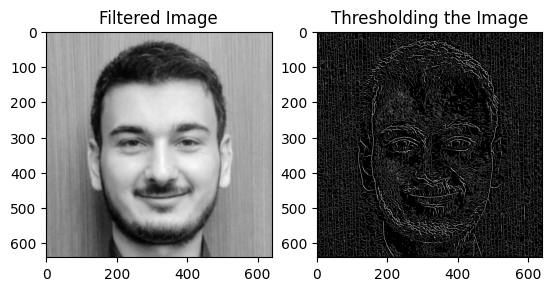

In [5]:
def threshold(img):

    highThreshold = img.max() * 0.17
    lowThreshold = highThreshold * 0.09

    M, N = img.shape
    res = numpy.zeros((M,N), dtype=numpy.int32)

    weak = numpy.int32(100)
    strong = numpy.int32(255)

    strong_i, strong_j = numpy.where(img >= highThreshold)
    zeros_i, zeros_j = numpy.where(img < lowThreshold)

    weak_i, weak_j = numpy.where((img <= highThreshold) & (img >= lowThreshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return (res)

thresholdImg = threshold(nonMaxImg)

pyplot.subplot(121)
pyplot.imshow(image_filtered,cmap = 'gray')
pyplot.title('Filtered Image')

pyplot.subplot(122)
pyplot.imshow(thresholdImg,cmap = 'gray')
pyplot.title('Thresholding the Image')

## Applying Hysteresis

Text(0.5, 1.0, 'Final Image')

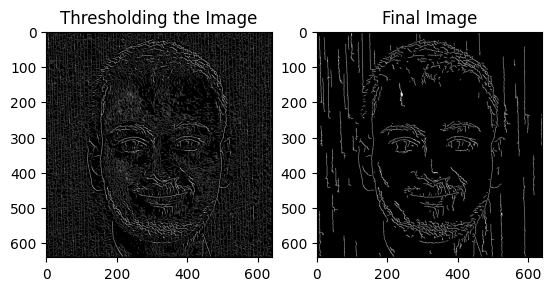

In [6]:

def hysteresis(img):

    img_copy = copy.deepcopy(img)
    M, N = img_copy.shape
    weak = 100
    strong = 255

    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img_copy[i,j] == weak):
                try:
                    if ((img_copy[i+1, j-1] == strong) or (img_copy[i+1, j] == strong) or (img_copy[i+1, j+1] == strong)
                        or (img_copy[i, j-1] == strong) or (img_copy[i, j+1] == strong)
                        or (img_copy[i-1, j-1] == strong) or (img_copy[i-1, j] == strong) or (img_copy[i-1, j+1] == strong)):
                        img_copy[i, j] = strong
                    else:
                        img_copy[i, j] = 0
                except IndexError as e:
                    pass

    return img_copy

my_own_canny = hysteresis(thresholdImg)

pyplot.subplot(121)
pyplot.imshow(thresholdImg,cmap = 'gray')
pyplot.title('Thresholding the Image')

pyplot.subplot(122)
pyplot.imshow(my_own_canny,cmap = 'gray')
pyplot.title('Final Image')

## Result Comparision with Open CV

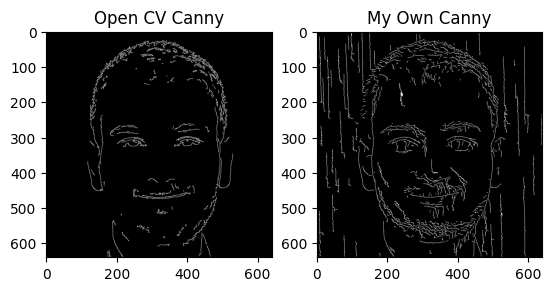

In [7]:
open_cv_canny = open_cv.Canny(orginal_img,100,200)

pyplot.subplot(121)
pyplot.imshow(open_cv_canny,cmap = 'gray')
pyplot.title('Open CV Canny')

pyplot.subplot(122)
pyplot.imshow(my_own_canny,cmap = 'gray')
pyplot.title('My Own Canny')

pyplot.show()

# References

* [[1] Open CV - Canny Edge Detection](https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html)
* [[2] Wikipedia - Canny Edge Detector](https://en.wikipedia.org/wiki/Canny_edge_detector)
* [[3] Sofiane Sahir - Article @ Towards Data Science](https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123)
* [[4] Sofiane Sahir - Github](https://github.com/FienSoP/canny_edge_detector)